The first explicit example of nonnegative polynomial that is not a sum of squares was found by Motzkin in 1967. By the [Arithmetic-geometric mean](https://en.wikipedia.org/wiki/Arithmetic%E2%80%93geometric_mean),
$$ \frac{x^4y^2 + x^2y^4 + 1}{3} \ge \sqrt[3]{x^4y^2 \cdot x^2y^4 \cdot 1} = x^2y^2 $$
hence
$$ x^4y^2 + x^2y^4 + 1 - 3x^2y^2 \ge 0. $$
The code belows construct the Motzkin polynomial using [DynamicPolynomials](https://github.com/JuliaAlgebra/DynamicPolynomials.jl).

In [1]:
using DynamicPolynomials
@polyvar x y
motzkin = x^4*y^2 + x^2*y^4 + 1 - 3x^2*y^2

x⁴y² + x²y⁴ - 3x²y² + 1

The Motzkin polynomial is nonnegative but is not a sum of squares as we can verify numerically as follows.
We first need to pick an SDP solver, see [here](http://www.juliaopt.org/JuMP.jl/dev/installation/#Getting-Solvers-1) for a list of the available choices.

In [2]:
using SumOfSquares, CSDP
factory = CSDP.Optimizer;

In [ ]:
using SumOfSquares, MosekTools
factory = Mosek.Optimizer;

In [3]:
model = SOSModel(factory)
@constraint(model, motzkin >= 0) # We constraint `motzkin` to be a sum of squares

(1)x⁴y² + (1)x²y⁴ + (-3)x²y² + (1) is SOS

In [4]:
optimize!(model)

CSDP 6.2.0
This is a pure primal feasibility problem.
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 8.21e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  3.2410827e+01 
Iter:  2 Ap: 9.49e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  3.0226979e+01 
Iter:  3 Ap: 8.52e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  5.8043991e+00 
Iter:  4 Ap: 4.43e-01 Pobj:  0.0000000e+00 Ad: 9.70e-01 Dobj: -2.0131592e+01 
Declaring primal infeasibility.


We see that the problem is detected as infeasible...

In [5]:
termination_status(model)

INFEASIBLE::TerminationStatusCode = 2

... and that the dual solution is a certificate of the infeasibility of the problem.

In [6]:
dual_status(model)

INFEASIBILITY_CERTIFICATE::ResultStatusCode = 4

Even if the Motzkin polynomial is not a sum of squares, it can still be certified to be nonnegative using sums of squares.
Indeed a polynomial is certified to be nonnegative if it is equal to a fraction of sums of squares.
The Motzkin polynomial is equal to a fraction of sums of squares whose denominator is $x^2 + y^2$.
This can be verified numerically as follows:

In [7]:
model = SOSModel(factory)
@constraint(model, (x^2 + y^2) * motzkin >= 0) # We constraint the `(x^2 + y^2) * motzkin` to be a sum of squares

(1)x⁶y² + (2)x⁴y⁴ + (1)x²y⁶ + (-3)x⁴y² + (-3)x²y⁴ + (1)x² + (1)y² is SOS

In [8]:
optimize!(model)

CSDP 6.2.0
This is a pure primal feasibility problem.
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.84e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  6.1906404e+01 
Iter:  2 Ap: 9.45e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  6.0656534e+01 
Iter:  3 Ap: 9.05e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  2.7707890e+01 
Iter:  4 Ap: 7.75e-01 Pobj:  0.0000000e+00 Ad: 8.23e-01 Dobj:  5.8982728e+00 
Iter:  5 Ap: 8.15e-01 Pobj:  0.0000000e+00 Ad: 9.46e-01 Dobj:  1.3960890e+00 
Iter:  6 Ap: 7.61e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  4.0730107e-01 
Iter:  7 Ap: 7.54e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  8.8693718e-02 
Iter:  8 Ap: 7.91e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  4.7142486e-02 
Iter:  9 Ap: 7.58e-01 Pobj:  0.0000000e+00 Ad: 9.68e-01 Dobj:  8.4582270e-03 
Iter: 10 Ap: 7.89e-01 Pobj:  0.0000000e+00 Ad: 1.00e+00 Dobj:  4.0179083e-03 
Iter: 11 Ap: 7.66e-01 Pobj:  0.0000000e+00 Ad: 9.92e-01 Dobj:  7.5288196e-04 
Iter: 12 A

Now the problem is declared feasible by the solver...

In [9]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

... and the primal solution is a feasible point, hence it is a certificate of nonnegativity of the Motzkin polynomial.

In [10]:
primal_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

One may consider ourself lucky to have had the intuition that $x^2 + y^2$ would work as denominator.
In fact, the search for the denominator can be carried out in parallel to the search of the numerator.
In the example below, we search for a denominator with monomials of degrees from 0 to 2.
If none is found, we can increase the maximum degree 2 to 4, 6, 8, ...
This gives a hierarchy of programs to try in order to certify the nonnegativity of a polynomial by identifying it with a fraction of sum of squares polynomials.
In the case of the Motzkin polynomial we now that degree 2 is enough since $x^2 + y^2$ works.

In [11]:
model = SOSModel(factory)
X = monomials([x, y], 0:2)

6-element MonomialVector{true}:
 x²
 xy
 y²
 x 
 y 
 1 

We create a quadratic polynomial that is not necessarily a sum of squares since this is implied by the next constraint: `deno >= 1`.

In [12]:
@variable(model, deno, Poly(X))

(noname)x² + (noname)xy + (noname)y² + (noname)x + (noname)y + (noname)

We want the denominator polynomial to be strictly positive, this prevents the trivial solution deno = 0 for instance.

In [13]:
@constraint(model, deno >= 1)

(noname)x² + (noname)xy + (noname)y² + (noname)x + (noname)y + (noname - 1) is SOS

In [14]:
@constraint(model, deno * motzkin >= 0)

(noname)x⁶y² + (noname)x⁵y³ + (noname + noname)x⁴y⁴ + (noname)x³y⁵ + (noname)x²y⁶ + (noname)x⁵y² + (noname)x⁴y³ + (noname)x³y⁴ + (noname)x²y⁵ + (-3 noname + noname)x⁴y² + (-3 noname)x³y³ + (-3 noname + noname)x²y⁴ + (-3 noname)x³y² + (-3 noname)x²y³ + (-3 noname)x²y² + (noname)x² + (noname)xy + (noname)y² + (noname)x + (noname)y + (noname) is SOS

In [15]:
optimize!(model)

CSDP 6.2.0
This is a pure primal feasibility problem.
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.95e-01 Pobj:  0.0000000e+00 Ad: 7.98e-01 Dobj: -1.4969375e+00 
Iter:  2 Ap: 8.28e-01 Pobj:  0.0000000e+00 Ad: 7.89e-01 Dobj:  3.6682062e-01 
Iter:  3 Ap: 8.25e-01 Pobj:  0.0000000e+00 Ad: 8.48e-01 Dobj: -4.2971015e-03 
Iter:  4 Ap: 7.85e-01 Pobj:  0.0000000e+00 Ad: 8.48e-01 Dobj:  1.9519502e-04 
Iter:  5 Ap: 7.02e-01 Pobj:  0.0000000e+00 Ad: 8.45e-01 Dobj: -1.7443054e-04 
Iter:  6 Ap: 6.84e-01 Pobj:  0.0000000e+00 Ad: 7.45e-01 Dobj:  3.4354877e-05 
Iter:  7 Ap: 6.59e-01 Pobj:  0.0000000e+00 Ad: 7.05e-01 Dobj: -1.2384593e-05 
Iter:  8 Ap: 7.09e-01 Pobj:  0.0000000e+00 Ad: 5.96e-01 Dobj: -8.3434950e-06 
Iter:  9 Ap: 6.92e-01 Pobj:  0.0000000e+00 Ad: 7.86e-01 Dobj:  1.3482976e-06 
Iter: 10 Ap: 7.08e-01 Pobj:  0.0000000e+00 Ad: 6.19e-01 Dobj: -2.1547496e-07 
Iter: 11 Ap: 6.29e-01 Pobj:  0.0000000e+00 Ad: 8.05e-01 Dobj:  1.1922145e-07 
Iter: 12 A

In [16]:
termination_status(model)

ALMOST_OPTIMAL::TerminationStatusCode = 7

In [17]:
primal_status(model)

NEARLY_FEASIBLE_POINT::ResultStatusCode = 2

We can check the denominator found by the program using `JuMP.getvalue`

In [18]:
value(deno)

11788.376578732263x² + 11788.412205445507y² + 20644.79368009344

Because a picture is worth a thousand words let's plot the beast.
We can easily extend `Plots` by adding a recipe to plot bivariate polynomials.

In [19]:
using RecipesBase
using MultivariatePolynomials
@recipe function f(x::AbstractVector, y::AbstractVector, p::Polynomial)
    x, y, (x, y) -> p(variables(p) => [x, y])
end

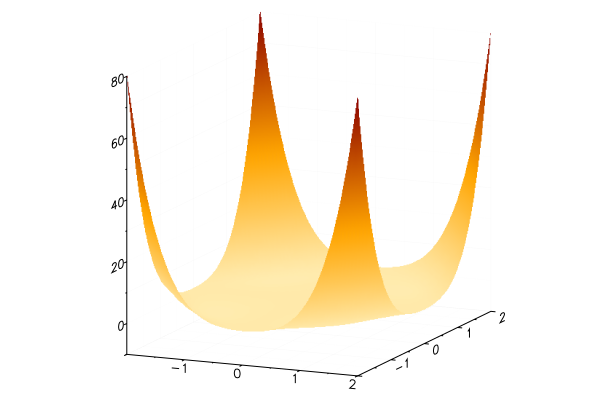

In [20]:
using Plots
plot(range(-2, stop=2, length=100), range(-2, stop=2, length=100), motzkin,
     st = [:surface], seriescolor=:heat, colorbar=:none, clims = (-10, 80))